<a href="https://colab.research.google.com/github/eduardez/Machine-Learning-ESI/blob/master/Dengue_Task2_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
%matplotlib inline
from google.colab import drive

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

#Autocorrelation
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# load the provided data
train_features_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=AGI3DY2BIJEZHXH6MWD42ZS77LZTE',
                             index_col=[0,1,2])

train_labels_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=AGI3DY6W2UZTEKJAKUJFXQC77LZVQ',
                             index_col=[0,1,2])

features_test_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_test.csv?token=AGI3DYYWLT5OHQAQYTJXKPK77LZP2',
                             index_col=[0,1,2])

submission = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/submission_format.csv?token=AGI3DY74P5TFADKZGDSLOZS77LZWM',
                             index_col=[0,1,2])

# Data gathering

In [ ]:
train_features = train_features_raw.copy()
train_labels = train_labels_raw.copy()

In [ ]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [ ]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

# Data shift

In [ ]:
def cross_corr(x, y, lag=0):
    return y.corr(x.shift(lag, fill_value = 0))


def shift_Factor(x, y, R):
    x_corr = [cross_corr(x, y, lag=i) for i in range(R)]
    
    # R factor is the number of the shifts who should be checked by the function
    Kot = pd.DataFrame(list(x_corr)).reset_index()
    Kot.rename(columns={0: 'Corr', 'index': 'Shift_num'}, inplace=True)
    # We find optimal correlation shift
    Kot['abs'] = Kot['Corr'].abs()
    SF = Kot.loc[Kot['abs'] == Kot['abs'].max(), 'Shift_num']
    p1 = SF.to_frame()
    SF = p1.Shift_num.max()

    return SF
#for generic dataset
def df_shif(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for h in df.columns:
        if h == target:
            new[h] = df[target]
        else:
            new[h] = df[h].shift(periods=lag, fill_value = 0)
    return  pd.DataFrame(data=new)

#for specific colum
def df_shif_column(df, dicc, replace=False, empty = False):
  if empty:
    resultado = df.copy()
    resultado = resultado.loc[:, resultado.columns == 'ndvi_ne']
    resultado.drop('ndvi_ne', axis = 1, inplace = True)
  else:
    resultado = df.copy()
  for item in dicc:
    if replace:
      resultado[item] = df[item].shift(periods=dicc[item], fill_value = 0)
    if not replace:
      if dicc[item] == 0:
        resultado[item] = df[item].shift(periods=dicc[item], fill_value = 0)
      else:
        resultado[item+'_'+str(dicc[item])+'_weeks'] = df[item].shift(periods = dicc[item], fill_value=0)
  return resultado

## Autoshift

In [ ]:
def autoshift(df, y, max_shift):
  output = pd.DataFrame() 
  for i in df.columns[1:]:
    x = df[i]
    SKO = shift_Factor(x, y, max_shift)
    print('Optimal shift for ' + i + ' : ', SKO)
    print(cross_corr(x, y, lag=SKO))
    output = output.append(df_shif(df, i, lag=SKO))
  return output

In [ ]:
R = 18 #week of maximun shift

sj_y = sj_train_labels.total_cases #target

autoshift(sj_train_features, sj_y, R)


Optimal shift for ndvi_ne :  16
0.07007438235040803
Optimal shift for ndvi_nw :  11
0.11348444488048025
Optimal shift for ndvi_se :  0
-0.12002352728990046
Optimal shift for ndvi_sw :  1
0.04853130424766568
Optimal shift for precipitation_amt_mm :  2
0.08115766017854417
Optimal shift for reanalysis_air_temp_k :  0
0.17940178147754643
Optimal shift for reanalysis_avg_temp_k :  0
0.17256852265608782
Optimal shift for reanalysis_dew_point_temp_k :  0
0.2010856585759715
Optimal shift for reanalysis_max_air_temp_k :  0
0.1926351222723707
Optimal shift for reanalysis_min_air_temp_k :  0
0.1855250089795826
Optimal shift for reanalysis_precip_amt_kg_per_m2 :  2
0.12414006771862637
Optimal shift for reanalysis_relative_humidity_percent :  0
0.14231697050664835
Optimal shift for reanalysis_sat_precip_amt_mm :  2
0.08115766017854417
Optimal shift for reanalysis_specific_humidity_g_per_kg :  6
0.2544301171441542
Optimal shift for reanalysis_tdtr_k :  2
-0.08014533509468681
Optimal shift for statio

week_start_date  ...  station_precip_mm
year weekofyear                  ...                   
1990 18                       0  ...                0.0
     19                       0  ...                0.0
     20                       0  ...                0.0
     21                       0  ...                0.0
     22                       0  ...                0.0
...                         ...  ...                ...
2008 13              2008-03-18  ...                1.8
     14              2008-03-25  ...                0.5
     15              2008-04-01  ...               30.7
     16              2008-04-08  ...               11.2
     17              2008-04-15  ...                0.3

[18720 rows x 21 columns]

In [ ]:
iq_y = iq_train_labels.total_cases
autoshift(iq_train_features, iq_y, R)

Optimal shift for ndvi_ne :  11
0.16379910221811905
Optimal shift for ndvi_nw :  11
0.17115059949936565
Optimal shift for ndvi_se :  14
0.13585410628788192
Optimal shift for ndvi_sw :  11
0.18355109450704232
Optimal shift for precipitation_amt_mm :  3
0.1310868312390422
Optimal shift for reanalysis_air_temp_k :  17
0.12613532883374398
Optimal shift for reanalysis_avg_temp_k :  17
0.12636013137547505
Optimal shift for reanalysis_dew_point_temp_k :  0
0.22886350764368768
Optimal shift for reanalysis_max_air_temp_k :  17
0.12995601206738314
Optimal shift for reanalysis_min_air_temp_k :  0
0.21085403645637485
Optimal shift for reanalysis_precip_amt_kg_per_m2 :  17
-0.10262637930640528
Optimal shift for reanalysis_relative_humidity_percent :  0
0.12854756120508248
Optimal shift for reanalysis_sat_precip_amt_mm :  3
0.1310868312390422
Optimal shift for reanalysis_specific_humidity_g_per_kg :  0
0.2349181568648318
Optimal shift for reanalysis_tdtr_k :  17
0.20559695914568402
Optimal shift for

week_start_date  ...  station_precip_mm
year weekofyear                  ...                   
2000 26                       0  ...                0.0
     27                       0  ...                0.0
     28                       0  ...                0.0
     29                       0  ...                0.0
     30                       0  ...                0.0
...                         ...  ...                ...
2010 21              2010-05-07  ...               27.0
     22              2010-05-14  ...               36.6
     23              2010-05-21  ...                7.4
     24              2010-05-28  ...               16.0
     25              2010-06-04  ...               20.4

[10400 rows x 21 columns]

## San Juan

In [ ]:
#SJ dictionary  | feature : shift
sj_dic = {
    'ndvi_ne': 16,
    'ndvi_nw': 11,
    'ndvi_se' : 0,
    'ndvi_sw' : 1,
    'precipitation_amt_mm':2,

    'reanalysis_air_temp_k' :0,
    'reanalysis_avg_temp_k':0,
    'reanalysis_dew_point_temp_k':0,
    'reanalysis_max_air_temp_k':0,
    'reanalysis_min_air_temp_k':0,

    'reanalysis_precip_amt_kg_per_m2':2,
    'reanalysis_relative_humidity_percent':0,
    'reanalysis_sat_precip_amt_mm':2,
    'reanalysis_specific_humidity_g_per_kg':6,
    'reanalysis_tdtr_k':2,

    'station_avg_temp_c':7,
    'station_diur_temp_rng_c':17,
    'station_max_temp_c':6,
    'station_min_temp_c':7,
    'station_precip_mm': 1
}
#Change boolean for replace or not

sj_train_1 = df_shif_column(sj_train_features,sj_dic, replace = True, empty=True)
sj_train_1



ndvi_ne  ndvi_nw  ...  station_min_temp_c  station_precip_mm
year weekofyear                    ...                                       
1990 18          0.00000  0.00000  ...                 0.0                0.0
     19          0.00000  0.00000  ...                 0.0               16.0
     20          0.00000  0.00000  ...                 0.0                8.6
     21          0.00000  0.00000  ...                 0.0               41.4
     22          0.00000  0.00000  ...                 0.0                4.0
...                  ...      ...  ...                 ...                ...
2008 13         -0.05950 -0.10825  ...                21.1                0.5
     14         -0.13305  0.03830  ...                21.1                1.8
     15         -0.13305 -0.21530  ...                21.7                0.5
     16          0.01480 -0.13540  ...                21.1               30.7
     17          0.00060 -0.00320  ...                21.1               11.2

[936 rows x 20 columns]

## Iquitos

In [ ]:

#Iq dictionary | feature : shift
iq_dic = {
    'ndvi_ne': 0,
    'ndvi_nw': 0,
    'ndvi_se' : 0,
    'ndvi_sw' : 0,
    'precipitation_amt_mm':0,
    'reanalysis_air_temp_k' :0,
    'reanalysis_avg_temp_k':0,
    'reanalysis_dew_point_temp_k':0,
    'reanalysis_max_air_temp_k':0,
    'reanalysis_min_air_temp_k':0,
    'reanalysis_precip_amt_kg_per_m2':0,
    'reanalysis_relative_humidity_percent':0,
    'reanalysis_sat_precip_amt_mm':0,
    'reanalysis_specific_humidity_g_per_kg':0,
    'reanalysis_tdtr_k':0,
    'station_avg_temp_c':0,
    'station_diur_temp_rng_c':0,
    'station_max_temp_c':0,
    'station_min_temp_c':0,
    'station_precip_mm': 0
}
#Change boolean for replace or not
iq_train_1 = df_shif_column(iq_train_features,iq_dic, replace = True, empty=True)
iq_train_1


ndvi_ne   ndvi_nw  ...  station_min_temp_c  station_precip_mm
year weekofyear                      ...                                       
2000 26          0.192886  0.132257  ...                20.7                3.0
     27          0.216833  0.276100  ...                20.8               55.6
     28          0.176757  0.173129  ...                20.7               38.1
     29          0.227729  0.145429  ...                14.7               30.0
     30          0.328643  0.322129  ...                19.1                4.0
...                   ...       ...  ...                 ...                ...
2010 21          0.342750  0.318900  ...                22.4               27.0
     22          0.160157  0.160371  ...                21.7               36.6
     23          0.247057  0.146057  ...                19.2                7.4
     24          0.333914  0.245771  ...                21.0               16.0
     25          0.298186  0.232971  ...                22.2               20.4

[520 rows x 20 columns]

# Random Forest


In [ ]:
sj_n_trains = int(sj_train_1.shape[0]*0.75)


sj_train_1_subtrain = sj_train_1.head(sj_n_trains)
sj_label_subtrain = sj_train_labels.head(sj_n_trains)

sj_train_1_subtest = sj_train_1.tail(sj_train_labels.shape[0]- sj_n_trains)
sj_label_subtest = sj_train_labels.tail(sj_train_labels.shape[0]- sj_n_trains)


print(sj_label_subtrain.shape)

(702, 1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint

from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
def report(results, n_top=3): 
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
param_dist = {"n_estimators": [32, 64, 128, 1024, 2048], # Number of trees in random forest
              "max_features": ['auto', 'sqrt'], # Number of features to consider at every split
              "max_depth": [8,4, 2], # Maximum number of levels in tree
              "min_samples_split": [2, 4, 6], #  Minimum number of samples required to split a node
              "min_samples_leaf": [8, 12, 16], # Minimum number of samples required at each leaf node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ['mae', 'mse']
            }

In [ ]:
regressor = RandomForestRegressor() 
regressor

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
grid_regres = GridSearchCV(estimator = regressor, param_grid= param_dist, cv = 5)

# Fit the random search model
grid_regres.fit(X = sj_train_1_subtrain, y = sj_label_subtrain)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
report(grid_regres.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: -0.065 (std: 0.104)
Parameters: {'bootstrap': True, 'criterion': 'mae', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 4, 'n_estimators': 64}

Model with rank: 2
Mean validation score: -0.066 (std: 0.119)
Parameters: {'bootstrap': True, 'criterion': 'mae', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 6, 'n_estimators': 64}

Model with rank: 3
Mean validation score: -0.068 (std: 0.109)
Parameters: {'bootstrap': False, 'criterion': 'mae', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 4, 'n_estimators': 32}

Model with rank: 4
Mean validation score: -0.068 (std: 0.095)
Parameters: {'bootstrap': True, 'criterion': 'mae', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 4, 'n_estimators': 32}

Model with rank: 5
Mean validation score: -0.069 (std: 0.086)
Parameters: {'bootstrap': True, 'criterion': 

In [ ]:
grid_regres.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=2, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=16,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=64, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# choose the best
best_grid = grid_regres.best_estimator_

# fit and predict
best_grid.fit( X = sj_train_1_subtrain, y = sj_label_subtrain)
y_pred = best_grid.predict(X = sj_train_1_subtest)

# EVALUATE 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(sj_label_subtest, y_pred)
print ('MAE', mae)

MAE 16.286258012820515


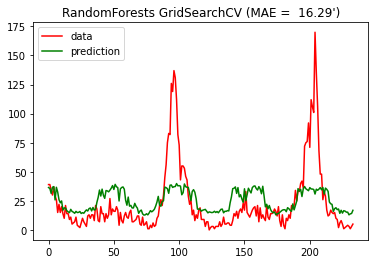

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(sj_label_subtest.shape[0]))
plt.plot(xx, sj_label_subtest , c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests GridSearchCV (MAE = %6.2f')" % ( mae))

plt.show()